In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                'machine-learning-databases'
                '/breast-cancer-wisconsin/wdbc.data',header=None)#위스콘신 유방암 데이터셋

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from sklearn.preprocessing import LabelEncoder
X= df.loc[:,2:].values

In [13]:
y = df.loc[:,1].values

In [14]:
y[:5]

array(['M', 'M', 'M', 'M', 'M'], dtype=object)

In [15]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_#M:악성, B:양성

array(['B', 'M'], dtype=object)

In [17]:
le.transform(['M','B'])

array([1, 0])

In [16]:
y[:5]

array([1, 1, 1, 1, 1])

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=1)

## 파이프라인을 사용한 효율적인 워크플로

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),#표준화
                        PCA(n_components=2),#주성분분석
                       LogisticRegression(solver='liblinear',random_state=1))#로지스틱 회귀

In [20]:
pipe_lr.fit(X_train,y_train)#훈련

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression',
                 LogisticRegression(random_state=1, solver='liblinear'))])

In [21]:
y_pred = pipe_lr.predict(X_test)#예측

In [23]:
print("테스트 정확도: %.3f"%pipe_lr.score(X_test,y_test))#정확도

테스트 정확도: 0.956


#### 계층적 k-겹 교차검증(stratified k-fold cross-validation)
: 클래스 비율이 전체 훈련 세트에 있는 클래스 비율을 대표하도록 유지

In [38]:
import numpy as np
from sklearn.model_selection import StratifiedKFold#계층적 k-겹 교차검증

In [39]:
kfold = StratifiedKFold(n_splits=10,shuffle=True,#10겹
                       random_state=1).split(X_train,y_train)

In [40]:
scores = []#정확도

In [41]:
for k,(train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])#훈련
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print("폴드: %2d, 클래스 분포:%s, 정확도: %.3f"%(k+1,np.bincount(y_train[train]),score))

폴드:  1, 클래스 분포:[256 153], 정확도: 0.913
폴드:  2, 클래스 분포:[256 153], 정확도: 1.000
폴드:  3, 클래스 분포:[256 153], 정확도: 0.957
폴드:  4, 클래스 분포:[256 153], 정확도: 0.978
폴드:  5, 클래스 분포:[256 153], 정확도: 0.870
폴드:  6, 클래스 분포:[257 153], 정확도: 0.933
폴드:  7, 클래스 분포:[257 153], 정확도: 0.956
폴드:  8, 클래스 분포:[257 153], 정확도: 0.978
폴드:  9, 클래스 분포:[257 153], 정확도: 0.978
폴드: 10, 클래스 분포:[257 153], 정확도: 0.911


In [42]:
print("\n CV 정확도: %.3f +/- %.3f"%(np.mean(scores),np.std(scores)))


 CV 정확도: 0.947 +/- 0.038


In [43]:
from sklearn.model_selection import cross_val_score#사이킷런의 k겹교차검증함수

In [44]:
scores = cross_val_score(estimator=pipe_lr,X=X_train,y=y_train, cv=10, n_jobs=1)#n_jobs=1: 하나의 CPU 코어만 성능평가에 사용

In [45]:
print("CV 정확도 점수: %s"%scores)

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [46]:
print("\n CV 정확도: %.3f +/- %.3f"%(np.mean(scores),np.std(scores)))


 CV 정확도: 0.950 +/- 0.014


### 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

In [58]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve#학습 곡선 함수

In [59]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear',penalty='l2',random_state=1))

In [60]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X = X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1,1.0,10),#일정한 간격으로 훈련세트의 비율 10개 설정
                                                       cv=10,#계층별 10겹 교차 검증
                                                       n_jobs=1)

In [61]:
train_mean = np.mean(train_scores,axis=1)#column따라 평균 내기
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

In [54]:
train_scores

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.99386503, 0.99386503, 0.99386503, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.98529412, 0.98529412, 0.98529412, 0.99019608, 0.99509804,
        0.99509804, 0.99509804, 0.99509804, 0.99509804, 0.99509804],
       [0.97959184, 0.98367347, 0.98367347, 0.9877551 , 0.9877551 ,
        0.9877551 , 0.9877551 , 0.9877551 , 0.9877551 , 0.9877551 ],
       [0.97902098, 0.98601399, 0.98251748, 0.98951049, 0.98951049,
        0.98951049, 0.98601399, 0.98601399, 0.98601399, 0.98601399],
       [0.98470948, 0.98470948, 0.9877675

In [53]:
train_mean2= np.mean(train_scores)#axis 없으면?
print(train_mean)
print("\n\n",train_mean2)

[1.         1.         1.         0.99815951 0.99166667 0.98612245
 0.98601399 0.98746177 0.9888587  0.98924205]


 0.9927525134004909


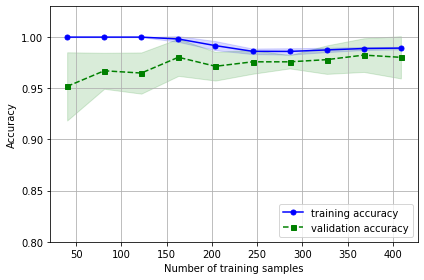

In [64]:
plt.plot(train_sizes, train_mean, color='blue',marker='o',markersize=5, label = 'training accuracy')#평균 훈련 정확도
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha = 0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green',linestyle = '--', marker = 's', markersize=5, label = 'validation accuracy')#교차검증정확도
plt.fill_between(train_sizes, test_mean+test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8,1.03])
plt.tight_layout()
plt.show()

### 검증곡선으로 과대적합과 과소적합 조사

In [66]:
from sklearn.model_selection import validation_curve#검증곡선
param_range = [0.001,0.001,0.1,1.0,10.0,100.0]#값 범위
train_scores, test_scores = validation_curve(#계층별 k-겹 교차검증
    estimator=pipe_lr,
    X = X_train,
    y = y_train,
    param_name='logisticregression__C',#평가: logistic regression의 규제 매개변수인 C
    param_range=param_range,
    cv = 10
)

In [67]:
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores, axis = 1)

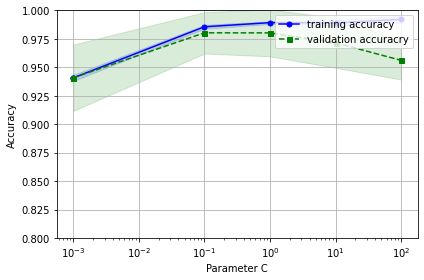

In [68]:

plt.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5,label='training accuracy')#평균 훈련 정확도
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha = 0.15, color = 'blue')#표준편차
plt.plot(param_range, test_mean, color = 'green', linestyle='--', marker='s',markersize=5, label='validation accuracry')#교차검증정확도
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color = 'green')#표준편차
plt.grid()
plt.xscale('log')
plt.legend(loc = 'upper right')
plt.xlabel('Parameter C')#매개변수 C에 대한 검증곡선 그래프
plt.ylabel('Accuracy')
plt.ylim([0.8,1.0])
plt.tight_layout()
plt.show()

### 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

In [69]:
from sklearn.model_selection import GridSearchCV#그리드서치
from sklearn.svm import SVC

In [70]:
pipe_svc = make_pipeline(StandardScaler(),#표준화
                         SVC(random_state=1))#SVM
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,
              'svc__kernel':['linear']},
             {'svc__C':param_range,
             'svc__gamma':param_range,
             'svc__kernel':['rbf']}]#튜닝하려는 매개변수를 딕셔너리의 리스트로 수정

In [71]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv =10,
                 n_jobs=-1)
gs = gs.fit(X_train,y_train)

In [72]:
print(gs.best_score_)

0.9846859903381642


In [73]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [74]:
clf = gs.best_estimator_

In [75]:
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])

In [76]:
print("테스트 정확도: %.3f"%clf.score(X_test,y_test))#정확도

테스트 정확도: 0.974


### 중첩 교차 검증
- 중첩된 교차 검증을 사용했을 때 테스트 세트에 대한 추정 오차는 거의 편향되지 않음
- 대용량 데이터셋에서 유용

In [86]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring = 'accuracy',
                 cv = 2)

In [87]:
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)#중첩교차검증(5x2)

In [88]:
print("CV 정확도: %.3f +/- %.3f"%(np.mean(scores),np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [81]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
                 scoring = 'accuracy',
                 cv=2)

In [85]:
print("CV 정확도: %.3f +/- %.3f"%(np.mean(scores),np.std(scores)))

CV 정확도: 0.974 +/- 0.015


### 여러가지 성능평가 지표

In [89]:
from sklearn.metrics import confusion_matrix#오차 행렬
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


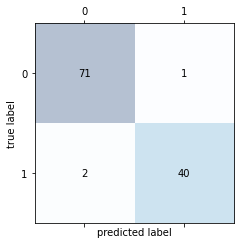

In [94]:
#오차행렬을 그림으로
fig,ax = plt.subplots(figsize=(3.5,3.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

<br><br>
오차
$$ERR = \frac{FP + FN}{FP + FN + TP + TN}$$
<br><br><br><br>
예측정확도
$$ACC = \frac{TP + TN}{FP + FN + TP + TN}$$
<br><br><br><br>
거짓 양성 비율
$$FPR = \frac{FP}{N}= \frac{FP}{FP + TN}$$
<br><br><br><br>
진짜 양성 비율
$$TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$$
<br><br><br><br>
정밀도
$$PRE = \frac{TP}{TP+FP}$$
<br><br><br><br>
재현율
$$REC = \frac{TP}{P} = \frac{TP}{FN + TP}$$
<br><br><br><br>
F1-점수
$$F1 = 2\frac{PRE X REC}{PRE + REC}$$


In [95]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print("정밀도: %.3f"%precision_score(y_true = y_test, y_pred=y_pred))
print("재현율: %.3f"%recall_score(y_true = y_test, y_pred=y_pred))
print("F1: %.3f"%f1_score(y_true = y_test, y_pred=y_pred))


정밀도: 0.976
재현율: 0.952
F1: 0.964


#### GridSearchCv의 scoring 매개변수를 사용하여 정확도 대신 다른 성능 지표 사용

In [96]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)#양성 레이블 바꾸기
c_gamma_range = [0.01,0.1,1.0,10.0]
param_grid = [{'svc__C':c_gamma_range,
              'svc__kernel':['linear']},
             {'svc__C':c_gamma_range,
             'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)
gs = gs.fit(X_train,y_train)

In [97]:
print(gs.best_score_)

0.9895936509889569


In [98]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__kernel': 'rbf'}


### ROC 곡선

ROC(Receiver Operating Characteristic) 그래프: 분류기의 임계 값을 바꾸어 가며 계산된 FPR(거짓 양성 비율)과 TDR(진짜 양성 비율) 점수를 기반으로 분류 모델을 선택하는 도구<br>
ROC곡선의 아래 면적인 <b>ROC AUC(ROC Area Under the Curver)</b>를 계산하여 분류 모델의 성능을 종합

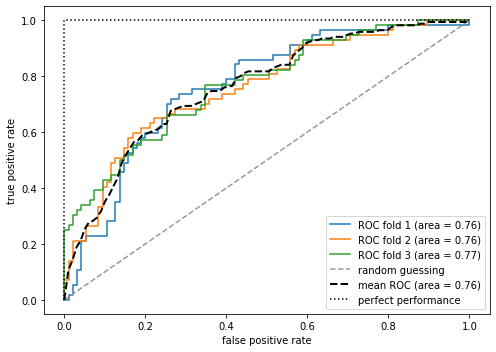

In [112]:
from sklearn.metrics import roc_curve,auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(solver='liblinear',
                                         penalty = 'l2',
                                         random_state=1,
                                          C=100.0))
X_train2 = X_train[:,[4,14]]
cv = list(StratifiedKFold(n_splits=3,shuffle=True, random_state=1).split(X_train,y_train))

fig = plt.figure(figsize=(7,5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr,fpr,tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,
            tpr,
            label='ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
plt.plot([0,1],
         [0,1],
         linestyle='--',
         color = (0.6,0.6,0.6),
         label = 'random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
        label = 'mean ROC (area = %0.2f)'%mean_auc, lw=2)

plt.plot([0,0,1],[0,1,1],linestyle=':',color = 'black', label = 'perfect performance')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

### 불균형한 클래스 다루기

In [113]:
#212개의 악성 종양(클래스 1)과 357개의 양성 종양(클래스 0)을 가진 유방암 데이터셋에서 불균형한 데이터셋

In [117]:
X_imb = np.vstack((X[y==0],X[y==1][:40]))
y_imb = np.hstack((y[y==0],y[y==1][:40]))

In [130]:
print(X_imb[y_imb == 1].shape)
print(X_imb[y_imb == 0].shape)
print(y_imb[y_imb == 0].shape)
print(y_imb[y_imb == 1].shape)

(40, 30)
(357, 30)
(357,)
(40,)


In [123]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb)*100

89.92443324937027

In [131]:
#소수 클래스의 샘플을 늘림
from sklearn.utils import resample
print('샘플링 하기 전 클래스 1의 개수:', X_imb[y_imb == 1].shape[0])

샘플링 하기 전 클래스 1의 개수: 40


In [132]:
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1],replace=True, n_samples= X_imb[y_imb == 0].shape[0],random_state=123)

In [133]:
print("샘플링 한 클래스 1의 샘플 개수:",X_upsampled.shape[0])

샘플링 한 클래스 1의 샘플 개수: 357


In [136]:
#샘플 추출한 후 클래스 0인 원본 샘플과 업샘플링된 클래스 1을 연결하여 균형 잡힌 데이터셋을 얻음
X_bal = np.vstack((X[y==0],X_upsampled))
y_bal = np.hstack((y[y==0],y_upsampled))

In [138]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal)*100#다수 클래스 예측하는 규칙: 50% 정확도

50.0

다운 샘플링(다수 클래스의 훈련 샘플 삭제하는 방법) 참고